### [Kernel Approximations](https://scikit-learn.org/stable/modules/kernel_approximation.html)

- These functions return *approximate feature maps* that correspond to kernels for use in SVMs, for example. They perform *non-linear transformations* on an input - this can be the basis for linear classifications or similar algorithms.

- The advantage of using approximate feature maps (compared to the kernel trick, which uses feature maps implicitly) is that explicit mappings can be better suited for online learning. They can significantly reduce the cost of learning with very large datasets. 

- Standard kernelized SVMs *do not scale well to large datasets*, but you can use much more efficient linear SVMs with approximate kernel maps. 

- Combining kernel map approximations with SGDClassifier makes non-linear learning on large datasets possible.

### [Nystroem Approximation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem)

- A general-purpose method for low-rank kernel approximations. It subsamples the data on which the kernel is evaluated. 

- Nystroem uses the `rbf` kernel by default but can use any kernel function or a precomputed kernel matrix. 

- `n_components` is the number of samples used - which is also the dimensionality of the computed features.

### [RBF Sampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html#sklearn.kernel_approximation.RBFSampler)

- `RBFSampler` constructs an approximate map for the radial basis function kernel, a.k.a. "Random Kitchen Sinks" [RR2007](https://scikit-learn.org/stable/modules/kernel_approximation.html#rr2007). 

- `fit` performs a Monte Carlo sampling. It takes two arguments: `n_components` (target dimensionality of the feature transform) and `gamma` the parameter of the RBF-kernel. 

- Higher `n_components` returns a better approximation of the kernel, so will yield results more similar to a kernel SVM.

- “Fitting” the feature function does not actually depend on the data - only its dimensionality.

- `transform` maps the data. Results may vary between different calls to `fit` due to inherent randomeness.

- For a given `n_components` *RBFSampler* is often less accurate than *Nystroem*. *RBFSampler* is cheaper to compute.

In [12]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]

X_features = RBFSampler(   gamma=1, random_state=1).fit_transform(X)
clf        = SGDClassifier(max_iter=50).fit(X_features, y)

clf.score(X_features, y)

1.0

### [Example: Approximating an RBF kernel](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)

- This shows how to use `RBF Sampler` and `Nystroem` to approximate an RBF kernel for SVM-based classification on the digits dataset.

- The results include those from a linear SVM (original space), linear SVM (approximate map) and a kernelized SVM.

- This dataset is not large enough to really show the benefits of kernel approximation - exact SVM is still reasonably fast.

- More sampling leads to better classification results, but with longer runtimes. Solving a linear SVM and approximate kernel SVM could be sped up using *stochastic gradient descent* via `SGDClassifier`.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import datasets, svm
from sklearn.pipeline import Pipeline as Pipe
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.decomposition import PCA

In [6]:
digits    = datasets.load_digits(n_class=9)
n_samples = len(digits.data)
data      = digits.data / 16.
data     -= data.mean(axis=0) #flatten the images

data_train, targets_train = (data[         :n_samples // 2],
                             digits.target[:n_samples // 2])
data_test, targets_test   = (data[          n_samples // 2:],
                             digits.target[ n_samples // 2:])

kernel_svm = svm.SVC(gamma=.2)
linear_svm = svm.LinearSVC()

feature_map_fourier  = RBFSampler(gamma=.2, random_state=1)
feature_map_nystroem = Nystroem(  gamma=.2, random_state=1)

fourier_approx_svm = Pipe([("feature_map", feature_map_fourier),
                           ("svm",         svm.LinearSVC())])

nystroem_approx_svm = Pipe([("feature_map", feature_map_nystroem),
                            ("svm",         svm.LinearSVC())])

In [7]:
kernel_svm_time = time()
kernel_svm.fit(data_train, targets_train)
kernel_svm_score = kernel_svm.score(data_test, targets_test)
kernel_svm_time = time() - kernel_svm_time

linear_svm_time = time()
linear_svm.fit(data_train, targets_train)
linear_svm_score = linear_svm.score(data_test, targets_test)
linear_svm_time = time() - linear_svm_time

sample_sizes = 30 * np.arange(1, 10)
fourier_scores = []
nystroem_scores = []
fourier_times = []
nystroem_times = []

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(data_train, targets_train)
    nystroem_times.append(time() - start)

    start = time()
    fourier_approx_svm.fit(data_train, targets_train)
    fourier_times.append(time() - start)

    fourier_score = fourier_approx_svm.score(data_test, targets_test)
    nystroem_score = nystroem_approx_svm.score(data_test, targets_test)
    nystroem_scores.append(nystroem_score)
    fourier_scores.append(fourier_score)

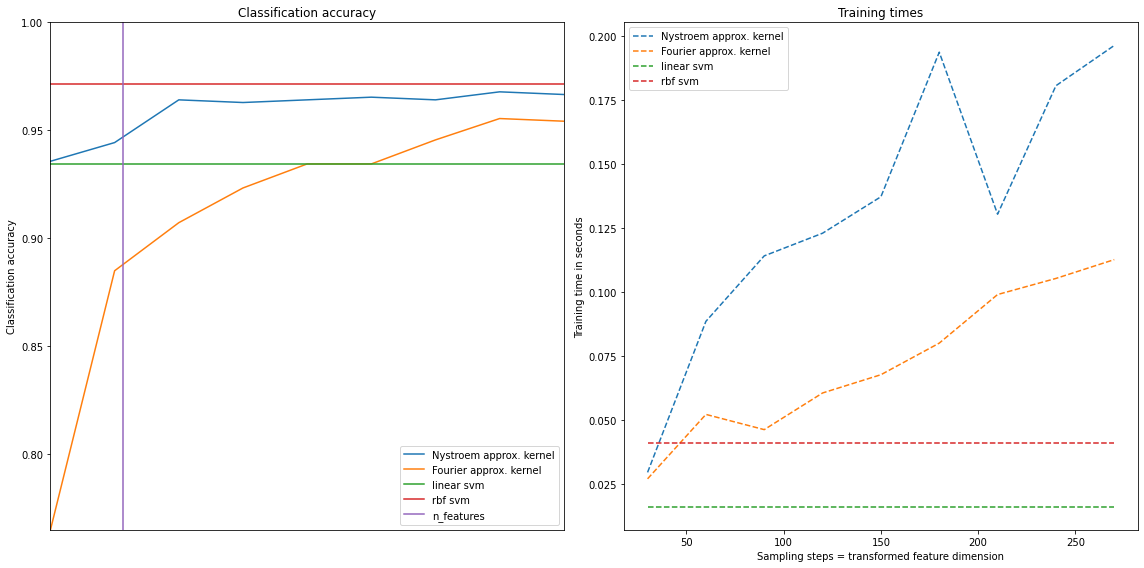

In [9]:
plt.figure(figsize=(16, 8))
accuracy = plt.subplot(121)
# second y axis for timings
timescale = plt.subplot(122)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')
plt.tight_layout()

- The second plot visualizes decision surfaces of the RBF kernel SVM and linear SVM with approximate kernel maps. 

- The decision surfaces of the classifiers are *projected onto the first two principal components* of the data. This visualization should be viewed with skepticism - it is just a slice through the decision surface in 64 dimensions. 

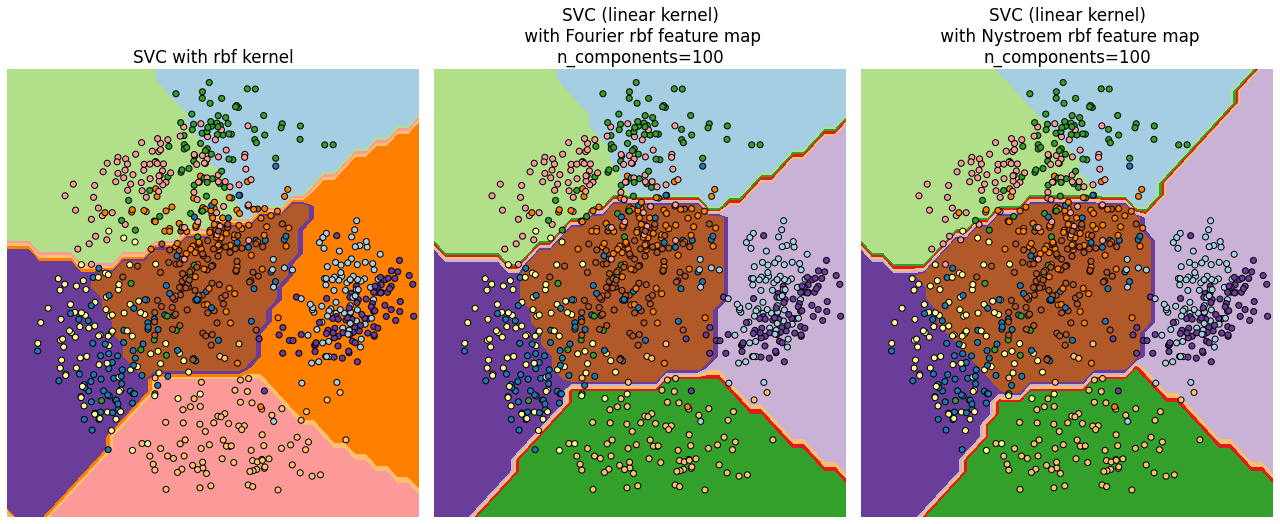

In [10]:
pca = PCA(n_components=8).fit(data_train)
X   = pca.transform(data_train)

# Generate grid along first two principal components
multiples = np.arange(-2, 2, 0.1)
# steps along first & second components - then combine
first     = multiples[:, np.newaxis] * pca.components_[0, :]
second    = multiples[:, np.newaxis] * pca.components_[1, :]
grid      = first[np.newaxis,:,:] + second[:,np.newaxis,:]
flat_grid = grid.reshape(-1, data.shape[1])

# title for the plots
titles = ['SVC with rbf kernel',
          'SVC (linear kernel)\n with Fourier rbf feature map\n'
          'n_components=100',
          'SVC (linear kernel)\n with Nystroem rbf feature map\n'
          'n_components=100']

plt.figure(figsize=(18, 7.5))
plt.rcParams.update({'font.size': 14})
# predict and plot
for i, clf in enumerate((kernel_svm, 
                         nystroem_approx_svm,
                         fourier_approx_svm)):

    # Plot decision boundary. Assign color to each point in the mesh
    plt.subplot(1, 3, i + 1)
    Z = clf.predict(flat_grid)
    Z = Z.reshape(grid.shape[:-1])
    plt.contourf(multiples, multiples, Z, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=targets_train, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.title(titles[i])
plt.tight_layout()

### [Additive Chi Squared Sampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.AdditiveChi2Sampler.html#sklearn.kernel_approximation.AdditiveChi2Sampler)

- The additive chi squared kernel is a kernel on histograms, often used in computer vision.

- Kernel definition: $k(x,y) = \sum_i \frac{2x_iy_i}{x_i+y_i}$

- Each component is sampled $n$ times yielding $2n+1$ dimensions per input dimension. (This is from the real & complex parts of a Fourier transform.) $n$ is usually chosen as 1 or 2; dataset size is transformed to `n_samples*5*n_features` (in the case of $n$=2.)

- The approximated feature map from this sampler can be combined with the result of an `RBF Sampler` to build an approximate feature map for an exponentiated chi-squared kernel.

In [14]:
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import AdditiveChi2Sampler

X, y          = load_digits(return_X_y=True)
chi2sampler   = AdditiveChi2Sampler(sample_steps=2)
X_transformed = chi2sampler.fit_transform(X, y)
clf           = SGDClassifier(max_iter=500, 
                              random_state=0, 
                              tol=1e-3).fit(X_transformed, y)
clf.score(X_transformed, y)

0.9821925431274346

### [Skewed Chi Squared Sampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.SkewedChi2Sampler.html#sklearn.kernel_approximation.SkewedChi2Sampler)

- Kernel definition: $k(x,y) = \prod_i \frac{2\sqrt{x_i+c}\sqrt{y_i+c}}{x_i+y_i+2c}$

- It is similar to the *exponentiated chi-squared* kernel and allows for a simple Monte Carlo approximation of the feature map.

- Usage is similar to that of `RBF Sampler` with the addition of the `c` parameter.

In [15]:
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.linear_model import SGDClassifier

X = [[0, 0], [1, 1], [1, 0], [0, 1]]
y = [0, 0, 1, 1]

X_features = SkewedChi2Sampler(skewedness=.01,
                               n_components=10,
                               random_state=0).fit_transform(X, y)

clf = SGDClassifier(max_iter=10, 
                    tol=1e-3).fit(X_features, y)
clf.score(X_features, y)

1.0

### [Polynomial Sampling via Tensor Sketch](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html#sklearn.kernel_approximation.PolynomialCountSketch)

- Kernel definition: $k(x, y) = (\gamma x^\top y +c_0)^d$

- $x$,$y$ = input vectors; $d$ = kernel "degree".

- TensorSketch is a scalable, input-data-independent method for polynomial kernel approximation. It is based on the concept of Count sketch, a dimensionality reduction technique similar to feature hashing, which instead uses several independent hash functions.

- TensorSketch obtains a Count Sketch of the outer product of two vectors (or a vector with itself), which can be used as an approximation of the polynomial kernel feature space. 

- Instead of explicitly computing the outer product, TensorSketch computes the Count Sketch of the vectors and then uses polynomial multiplication via the Fast Fourier Transform to compute the Count Sketch of their outer product.

### [Example: scaling learning with polynomial kernel approximation](https://scikit-learn.org/stable/auto_examples/kernel_approximation/plot_scalable_poly_kernels.html#sphx-glr-auto-examples-kernel-approximation-plot-scalable-poly-kernels-py)

- Using the Covtype dataset (581K samples, 54 features/sample, 6 classes; describes forest cover type from cartography only.)

- After loading, transform to binary classification problem to match the dataset version in the LIBSVM web page.

In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.pipeline import Pipeline, make_pipeline
import time

In [22]:
# select 5K/10K samples for training/testing
X, y = fetch_covtype(return_X_y=True)

y[y != 2] = 0
y[y == 2] = 1  # separate class 2 from other 6 classes.

X_train, X_test, y_train, y_test = TTS(X, y, 
                                       train_size=5_000,
                                       test_size=10_000,
                                       random_state=42)

mm      = make_pipeline(MinMaxScaler(), Normalizer())
X_train = mm.fit_transform(X_train)
X_test  = mm.transform(X_test)

# baseline: train linear SVM on original data, print accuracy

results = {}
lsvm = LinearSVC()
start = time.time()
lsvm.fit(X_train, y_train)
lsvm_time = time.time() - start
lsvm_score = 100 * lsvm.score(X_test, y_test)

results["LSVM"] = {"time": lsvm_time, "score": lsvm_score}
print(f"Linear SVM score on raw features: {lsvm_score:.2f}%")

Linear SVM score on raw features: 75.62%


- Train linear SVMs on features generated by `PolynomialCountSketch` with different values for `n_components`.

- `n_components` should be > #features in the input representation to see a linear classification improvement. As a rule of thumb, use `n_components=10*n_features`. 

- Given the original samples have 54 features, the explicit feature map of a polynomial kernel of degree four would have ~8.5M features (54^4). PolynomialCountSketch condenses the discriminative information into a much more compact representation. We repeat the experiment 5 times to compensate for the stochastic nature of PolynomialCountSketch.

In [23]:
n_runs = 3
for n_components in [250, 500, 1000, 2000]:

    ps_lsvm_time = 0
    ps_lsvm_score = 0
    for _ in range(n_runs):

        pipeline = Pipeline(steps=[("kernel_approximator",
                                    PolynomialCountSketch(
                                        n_components=n_components,
                                        degree=4)),
                                   ("linear_classifier", LinearSVC())])

        start = time.time()
        pipeline.fit(X_train, y_train)
        ps_lsvm_time += time.time() - start
        ps_lsvm_score += 100 * pipeline.score(X_test, y_test)

    ps_lsvm_time /= n_runs
    ps_lsvm_score /= n_runs

    results[f"LSVM + PS({n_components})"] = {
        "time": ps_lsvm_time, "score": ps_lsvm_score
    }
    print(f"Linear SVM score on {n_components} PolynomialCountSketch " +
          f"features: {ps_lsvm_score:.2f}%")

Linear SVM score on 250 PolynomialCountSketch features: 76.17%
Linear SVM score on 500 PolynomialCountSketch features: 77.55%
Linear SVM score on 1000 PolynomialCountSketch features: 77.90%
Linear SVM score on 2000 PolynomialCountSketch features: 78.31%


- Train a kernelized SVM to see how well `PolynomialCountSketch` approximates the kernel. SVC has poor scalability - so this may take some time. (This is why kernel approximators are useful.)

In [24]:
from sklearn.svm import SVC

ksvm = SVC(C=500., kernel="poly", degree=4, coef0=0, gamma=1.)

start = time.time()
ksvm.fit(X_train, y_train)
ksvm_time = time.time() - start
ksvm_score = 100 * ksvm.score(X_test, y_test)

results["KSVM"] = {"time": ksvm_time, "score": ksvm_score}
print(f"Kernel-SVM score on raw featrues: {ksvm_score:.2f}%")

Kernel-SVM score on raw featrues: 79.78%


- Plot the methods against their training times. Kernelized SVM has higher accuracy but much long training time & will grow much faster if the number of training samples grows.

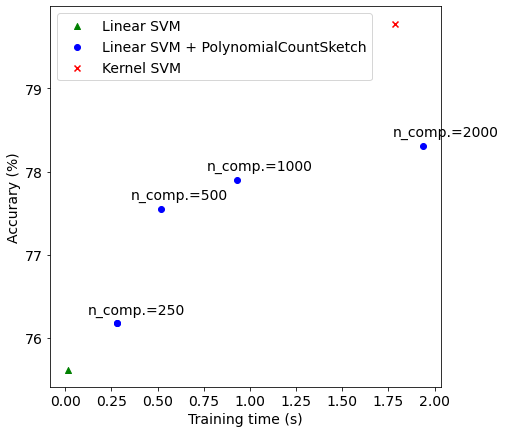

In [25]:
N_COMPONENTS = [250, 500, 1000, 2000]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter([results["LSVM"]["time"], ], [results["LSVM"]["score"], ],
           label="Linear SVM", c="green", marker="^")

ax.scatter([results["LSVM + PS(250)"]["time"], ],
           [results["LSVM + PS(250)"]["score"], ],
           label="Linear SVM + PolynomialCountSketch", c="blue")
for n_components in N_COMPONENTS:
    ax.scatter([results[f"LSVM + PS({n_components})"]["time"], ],
               [results[f"LSVM + PS({n_components})"]["score"], ],
               c="blue")
    ax.annotate(f"n_comp.={n_components}",
                (results[f"LSVM + PS({n_components})"]["time"],
                 results[f"LSVM + PS({n_components})"]["score"]),
                xytext=(-30, 10), textcoords="offset pixels")

ax.scatter([results["KSVM"]["time"], ], [results["KSVM"]["score"], ],
           label="Kernel SVM", c="red", marker="x")

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accurary (%)")
ax.legend()